Import packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

Load all images in test_images folder

In [2]:
import os
list_images = os.listdir("test_images/")
test_images = []
for image in list_images:
    #reading in an image
    image = mpimg.imread("test_images/" + image)
    test_images.append(image)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    #plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


Helper functions

In [9]:
def color_treshold(image):
    upper = np.uint8([255, 255, 255])
    
    # white color mask
    lower = np.uint8([200, 200, 200])
    white_mask = cv2.inRange(image, lower, upper)
    
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    yellow_mask = cv2.inRange(image, lower, upper)
    
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    mpimg.imsave("test_images_result/color.jpg", masked)
    return masked

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for i in range(0,len(lines)):
        x1,y1,x2,y2 = lines[i]
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_lanes(image, lines):
    rightLines, leftLines = separate_lines_by_slope(lines, image.shape[1]/2)
    rightLanePoints = get_lane_points(rightLines, image.shape[0])
    
    leftLanePoints = get_lane_points(leftLines, image.shape[0])
    points = []
    points. append(rightLanePoints)
    points. append(leftLanePoints)
    #points = np.array(rightLanePoints)
    #points.append(leftLanePoints)
    #points = np.append([rightLanePoints],[leftLanePoints] )
    draw_lines(image, np.array(points), thickness=5)
    #draw_lines(image, leftLanePoints = draw_lane(leftLines), thickness=5)
            
def separate_lines_by_slope(lines, center_x):
    rightLanes = []
    leftLanes = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (float(y2)-y1)/(x2-x1)
            if slope >= 0 and x1 > center_x and x2 > center_x:
                leftLanes.append([x1,y1,x2,y2])
            elif slope < 0 and x1 < center_x and x2 < center_x:
                rightLanes.append([x1,y1,x2,y2])
    right = np.array(rightLanes)
    left = np.array(leftLanes)
    return right, left

def get_lane_points(lines, lane_start_coord_y):
    lineX = []
    lineY = []
    for i in range(0,len(lines)):
        x1,y1,x2,y2 = lines[i,:]
        lineX.append(x1)
        lineX.append(x2)

        lineY.append(y1)
        lineY.append(y2)
        
    # fit is a function that takes x and returns y
    coeffs = np.polyfit(lineX, lineY, 1)
   # print ("coeffs: ", coeffs)
    minY = min(lineY)
    maxY = lane_start_coord_y
    points = []
    #minY = coeffs[0]*minX + coeffs[1]
    minX = (minY - coeffs[1])/coeffs[0]
    #maxY = coeffs[0]*maxX + coeffs[1]
    maxX = (maxY - coeffs[1])/coeffs[0]
    points.append(int(minX))
    points.append(int(minY))
    points.append(int(maxX))
    points.append(int(maxY))
    points = np.array(points)
    return points

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    draw_lanes(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

Process_image takes image from file as an arguments and returns fully processed image with lines on top of road lane as a result

In [4]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    processed_image = color_treshold(image)
    processed_image = grayscale(processed_image)
    processed_image = gaussian_blur(processed_image, 5)
    processed_image = canny(processed_image, 50, 150)
    #lanes are roughly in the same position on every image and shape below seems to fit it just right
    vertices = np.array([[(40,image.shape[0]),(470, 320), (500, 320), (image.shape[1]-20,image.shape[0])]], dtype=np.int32)
    processed_image = region_of_interest(processed_image, vertices)
    processed_image = hough_lines(processed_image, 2, np.pi/180, 15, 3, 5)
    mpimg.imsave("test_images_result/mask.jpg", processed_image)
    processed_image = weighted_img(processed_image, image)
    return processed_image


Iterate over every test image, process it and save to test_images_result

TypeError: expected non-empty vector for x

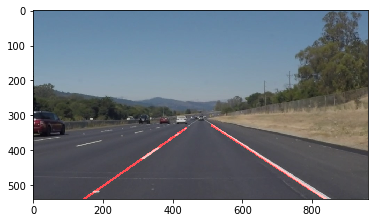

In [5]:
for i in range(0,len(test_images)):
    image_result = process_image(test_images[i])
    plt.imshow(image_result)
    mpimg.imsave("test_images_result/" + list_images[i], image_result)

Video processing

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████▊| 221/222 [00:31<00:00,  7.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 32.1 s


In [ ]:
white_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

This line plays wideo inline

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Challenge

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))